In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

from scipy.stats import randint as sp_randint

from keras.models import Sequential
from keras.layers import Dense

In [2]:
train = pd.read_csv('train.csv')
train

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,...,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,...,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,...,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,...,0,0,0,0,0,0,0,0,0,0


This dataset contains an anonymized set of variables, each representing a custom feature in a Mercedes car. For example, a variable could be 4WD, added air suspension, or a head-up display.

The ground truth is labeled ‘y’ and represents the time (in seconds) that the car took to pass testing for each variable.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [4]:
train.describe()

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4209.000000,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,4205.960798,100.669318,0.013305,0.0,0.075077,0.057971,0.428130,0.000475,0.002613,0.007603,...,0.318841,0.057258,0.314802,0.020670,0.009503,0.008078,0.007603,0.001663,0.000475,0.001426
std,2437.608688,12.679381,0.114590,0.0,0.263547,0.233716,0.494867,0.021796,0.051061,0.086872,...,0.466082,0.232363,0.464492,0.142294,0.097033,0.089524,0.086872,0.040752,0.021796,0.037734
min,0.000000,72.110000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2095.000000,90.820000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4220.000000,99.150000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6314.000000,109.010000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8417.000000,265.320000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
X, y = train.drop(['ID', 'y'], axis=1), train['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
cols_num = X.select_dtypes(include = ['int64', 'float64']).columns
cols_cat = X.select_dtypes(include = ['object']).columns

trans_num = StandardScaler()

In [84]:
corr = X[cols_num].corr()
corr

,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
X10,1.000000,-0.002146,-0.039453,-0.035496,-0.120379,-0.003717,-0.007125,-0.013108,-0.014142,-0.049351,...,0.189023,-0.031817,-0.086214,-0.019498,-0.015262,-0.012561,-0.013108,-0.003035,-0.003717,-0.005681
X11,-0.002146,1.000000,-0.004369,-0.003931,0.017825,-0.000412,-0.000789,-0.001452,-0.001566,-0.005466,...,-0.010720,-0.003524,-0.010380,-0.002159,-0.001690,-0.001391,-0.001452,-0.000336,-0.000412,-0.000629
X12,-0.039453,-0.004369,1.000000,0.283228,-0.245127,-0.007570,-0.014509,-0.016991,-0.028796,-0.100493,...,-0.148812,-0.064790,0.080843,-0.006747,-0.022720,-0.025578,-0.016991,-0.006180,-0.007570,-0.011569
X13,-0.035496,-0.003931,0.283228,1.000000,-0.076145,-0.006811,-0.013054,-0.024015,-0.025908,-0.090413,...,-0.177340,-0.058291,0.359450,-0.035722,-0.027961,0.054582,-0.024015,-0.005560,-0.006811,-0.010408
X14,-0.120379,0.017825,-0.245127,-0.076145,1.000000,-0.023097,-0.044269,0.000864,-0.087862,-0.306620,...,0.107496,0.043260,-0.139742,-0.051238,0.113487,0.007787,0.000864,0.025212,0.030881,0.047195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X380,-0.012561,-0.001391,-0.025578,0.054582,0.007787,-0.002410,-0.004619,-0.008498,0.043621,-0.023568,...,-0.062756,-0.020628,-0.060764,-0.012641,-0.009895,1.000000,-0.008498,-0.001968,-0.002410,-0.003683
X382,-0.013108,-0.001452,-0.016991,-0.024015,0.000864,-0.002515,-0.004821,1.000000,0.066366,-0.033389,...,-0.065490,-0.021526,-0.063411,-0.013192,-0.010326,-0.008498,1.000000,-0.002053,-0.002515,-0.003844
X383,-0.003035,-0.000336,-0.006180,-0.005560,0.025212,-0.000582,-0.001116,-0.002053,-0.002215,-0.007730,...,-0.015163,-0.004984,0.008850,-0.003054,-0.002391,-0.001968,-0.002053,1.000000,-0.000582,-0.000890
X384,-0.003717,-0.000412,-0.007570,-0.006811,0.030881,-0.000713,-0.001367,-0.002515,-0.002713,-0.009469,...,0.000420,-0.006105,0.020448,-0.003741,-0.002928,-0.002410,-0.002515,-0.000582,1.000000,-0.001090


<AxesSubplot:>

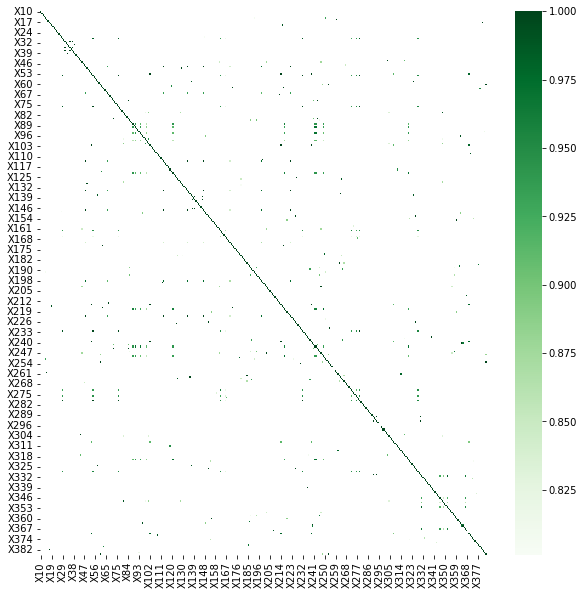

In [85]:
corr_plot = corr[corr>=.8]
plt.figure(figsize=(10,10))
sn.heatmap(corr_plot, cmap="Greens")

In [86]:
corr.unstack().sort_values().drop_duplicates()

X156  X157   -1.000000
X232  X136   -1.000000
X204  X205   -1.000000
X186  X194   -0.999523
X158  X142   -0.999338
                ...   
X54   X279    0.996896
X129  X49     0.998975
X202  X247    0.999348
X384  X384    1.000000
X10   X257         NaN
Length: 49637, dtype: float64

In [98]:
corr['X156']['X157']

-1.0000000000000004

In [95]:
corr['X156'][0]

-0.20624612407566828

In [7]:
transformer_numerical = Pipeline(steps = [('scaler', StandardScaler()),
                                          ('pca', None)])
transformer_categorical = Pipeline(steps = [('encoder', OneHotEncoder(drop='first',
                                                                     handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers = [('numerical', transformer_numerical, cols_num),
                                               ('categorical', transformer_categorical, cols_cat)])

In [8]:
pipe = Pipeline(steps = [('preprocessor', preprocessor), ('model', None)])

In [9]:
param_grid = [
    {
        'preprocessor__numerical__pca' : [PCA(n_components=0.95), None],
        'model__n_estimators' : sp_randint(200, 500),
        'model__max_depth' : np.arange(1, 11, 1),
        'model__min_samples_split' : np.arange(2, 10, 1),
        'model__min_samples_leaf' : sp_randint(1, 12),
        'model__ccp_alpha' : [0, 0.0001, 0.001, 0.01, 0.1, 5, 10, 50, 100, 500, 1000],
        'model': [RandomForestRegressor()]
    },
    {
        'preprocessor__numerical__scaler' : [StandardScaler(), MinMaxScaler()],
        'preprocessor__numerical__pca' : [PCA(n_components=0.95), None],
        'model__learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive'],
        'model__alpha' : [0, 0.0001, 0.001, 0.01, 0.1, 5, 10, 50, 100, 500, 1000],
        'model': [SGDRegressor()]
    },
    {
        'preprocessor__numerical__pca' : [PCA(n_components=0.95), None],
        'model__n_estimators' : sp_randint(10, 100),
        'model__max_depth': np.arange(2, 9),
        'model__learning_rate': np.arange(0.01, 0.3, 0.01),
        'model__colsample_bytree': np.arange(0.1, 1, 0.1),
        'model__gamma': np.arange(0, 20, 2),
        'model': [XGBRegressor()]
    }

]
grid = RandomizedSearchCV(pipe, param_grid, n_iter=300, scoring='r2')
grid.fit(X_train, y_train)

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarn

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarn

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: F

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarn

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarn

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: F

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarn

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarn

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: Use

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarn

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: F

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarn

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler()),
                                                                                               ('pca',
                                                                                                None)]),
                                                                               Index(['X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=368)),
                                                                              ('categorical',
                                                                               P...
                                         'model__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
                                         'model__max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                                         'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000242941D7460>,
                                         'preprocessor__numerical__pca': [PCA(n_components=0.95),
                                                                          None]}],
                   scoring='r2')

In [22]:
pd.set_option('display.max_colwidth', 1000)
pd.DataFrame(grid.cv_results_).sort_values(by = 'rank_test_score')[['params',
                                                                    'mean_fit_time',
                                                                    'mean_test_score']]

,params,mean_fit_time,mean_test_score
37,"{'model': RandomForestRegressor(ccp_alpha=0, max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=416), 'model__ccp_alpha': 0, 'model__max_depth': 5, 'model__min_samples_leaf': 6, 'model__min_samples_split': 4, 'model__n_estimators': 416, 'preprocessor__numerical__pca': None}",10.845748,5.616380e-01
43,"{'model': RandomForestRegressor(ccp_alpha=0, max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=416), 'model__ccp_alpha': 0.1, 'model__max_depth': 6, 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 497, 'preprocessor__numerical__pca': None}",13.852232,5.615804e-01
3,"{'model': RandomForestRegressor(ccp_alpha=0, max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=416), 'model__ccp_alpha': 5, 'model__max_depth': 10, 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 315, 'preprocessor__numerical__pca': None}",11.361485,5.605989e-01
82,"{'model': RandomForestRegressor(ccp_alpha=0, max_depth=5, min_samples_leaf=6, min_samples_split=4, n_estimators=416), 'model__ccp_alpha': 5, 'model__max_depth': 7, 'model__min_samples_leaf': 7, 'model__min_samples_split': 2, 'model__n_estimators': 345, 'preprocessor__numerical__pca': None}",10.501370,5.600808e-01
65,"{'model': XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, reg_alpha=None, reg_lambda=None, ...), 'model__colsample_bytree': 0.2, 'model__gamma': 4, 'model__learning_rate': 0.27, 'model__max_depth': 2, 'model__n_estimators': 27, 'preprocessor__numerical__pca': None}",0.135837,5.599587e-01
...,...,...,...
47,"{'model': SGDRegressor(), 'model__alpha': 0.0001, 'model__learning_rate': 'adaptive', 'preprocessor__numerical__pca': None, 'preprocessor__numerical__scaler': StandardScaler()}",4.546582,-6.780048e+17
49,"{'model': SGDRegressor(), 'model__alpha': 0.01, 'model__learning_rate': 'optimal', 'preprocessor__numerical__pca': None, 'preprocessor__numerical__scaler': StandardScaler()}",0.372527,-3.165935e+19
64,"{'model': SGDRegressor(), 'model__alpha': 0.01, 'model__learning_rate': 'invscaling', 'preprocessor__numerical__pca': None, 'preprocessor__numerical__scaler': StandardScaler()}",0.069235,-8.302861e+19
81,"{'model': SGDRegressor(), 'model__alpha': 0.1, 'model__learning_rate': 'invscaling', 'preprocessor__numerical__pca': PCA(n_components=0.95), 'preprocessor__numerical__scaler': StandardScaler()}",0.185416,-1.803936e+20


In [11]:
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   None)]),
                                                  Index(['X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=368)),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object'))])),
                ('model',
                 RandomForestRegressor(ccp_alpha=0, max_depth=5,
                                       min_samples_leaf=6, min_samples_split=4,
                                       n_estimators=416))])

In [12]:
grid.best_estimator_.fit(X_train, y_train)
r2_score(y_test, grid.best_estimator_.predict(X_test))
#0.5901821334115114
#0.5963850181058674

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.59479861871087

In [13]:
model = Sequential()
model.add(Dense(12, input_shape=(563,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                6768      
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6,881
Trainable params: 6,881
Non-trainable params: 0
_________________________________________________________________


In [14]:
X = pd.get_dummies(X)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
_, accuracy = model.evaluate(X, y)

132/132 [==============================] - 0s 987us/step - loss: 26.6449 - accuracy: 0.0000e+00


In [15]:
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 0.00


In [16]:
test = pd.read_csv('test.csv')
test

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8410,aj,h,as,f,d,aa,j,e,0,...,0,0,0,0,0,0,0,0,0,0
4205,8411,t,aa,ai,d,d,aa,j,y,0,...,0,1,0,0,0,0,0,0,0,0
4206,8413,y,v,as,f,d,aa,d,w,0,...,0,0,0,0,0,0,0,0,0,0
4207,8414,ak,v,as,a,d,aa,c,q,0,...,0,0,1,0,0,0,0,0,0,0


In [17]:
X = test.drop(['ID'], axis=1)

In [18]:
results = pd.DataFrame({'ID' : test['ID'], 'y' : grid.best_estimator_.predict(X)})
results

D:\anaconda\envs\merc\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,ID,y
0,1,77.872832
1,2,93.991619
2,3,77.367185
3,4,77.550214
4,5,112.479025
...,...,...
4204,8410,102.990714
4205,8411,95.806210
4206,8413,93.900029
4207,8414,111.855891


In [19]:
#results.to_csv('submission.csv', index=False)